In [1]:
'''Trains a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for more details).

# References
- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU

15/04/2020
Tensorflow 2 keras version
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random

import matplotlib.pyplot as plt
import cv2

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

num_classes = 10

print("tf2=",tf.__version__)

tf2= 2.1.0


In [2]:
def rotate(img, angle):
    #img = cv2.imread(img)
    (height, width) = img.shape[:2]
    (cent_x, cent_y) = (width // 2, height // 2)
    mat = cv2.getRotationMatrix2D((cent_x, cent_y), -angle, 1.0)
    return cv2.warpAffine(img, mat,(height, width))

In [22]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss_intra_easy(y,d):
    '''    Double contrastive loss from me 2019    '''
    # splitting data
    #labels n for same class and r for samem orientation/rotation
    # 11 distance for same class same rotation/orientation -> squeeze
    # 10 distance for same class different orientation -> squeeze up to a margin
    # 00 diatance for different class -> stretch up to a margin
    #y_r label is not used
    y_n,y_r= tf.split(y,2, axis=-1)
    d_pred=d

    # margins for relative is little since it is in the ball of normal margin
    margin_n = 2.0
    #margin_r = 0.25
    
    # same importance const
    #cs=margin_n/margin_r
    
    square_pred = K.square(d_pred)
    
    margin_square_00  = K.square(K.maximum(margin_n - d_pred, 0))# -> stretch up to a margin margin_n
    margin_square_10n = K.square(K.maximum(d_pred   - margin_n, 0)) # -> squeeze up to a margin
    #margin_square_10r = K.square(K.maximum(margin_r - d_pred,0))  # -> stretch up to margin margin_r
    
    # relative loss from embedding vector differences
    #loss_11=square_pred                   #-> squeeze
    #loss_10= margin_square_10n+margin_square_10r # -> squeeze up to a margin_n but stretch up to margin_r
    #loss_1 = y_r * loss_11 + (1-y_r) * loss_10
    loss_1 = margin_square_10n
    loss_0 = margin_square_00               # -> max up to a margin
    # main loss from embedding vectors
    loss= y_n * loss_1 + (1 - y_n) *  loss_0
    # merging losses
    loss=K.mean(loss)
    return loss


In [4]:
def create_pairs_intra(x,digit_indices,N=2,classes=[0,3,4,8,9]):
    #subclases=[0,1]
    label=range(len(classes))
    sublabel=[i+0.5 for i in label]
    dx=[]
    dy=[]
    d_n={}
    d_r={}
    for n in classes:
        d_n[n]=[]
        d_r[n]=[]
    for ni,n in enumerate(classes):
        for i in range(N):
            d_ni=x[digit_indices[n][i]]
            d_ri=rotate(d_ni,30)
            d_n[n].append(d_ni)
            d_r[n].append(d_ri)
            dx.append(d_ni)
            dy.append(label[ni])
            dx.append(d_ri)
            dy.append(sublabel[ni])
    pairs=[]
    labels=[]
    for na in range(len(classes)):
        a=classes[na]
        for nb in range(na+1,len(classes)):
            b=classes[nb]
            for i in range(N):
                dani=d_n[a][i]
                dari=d_r[a][i]
                dbni=d_n[b][i]
                dbri=d_r[b][i]
                for j in range(i+1,N):
                    danj=d_n[a][j]
                    darj=d_r[a][j]
                    dbnj=d_n[b][j]
                    dbrj=d_r[b][j]
                    pairs +=[[dani,danj]]
                    labels+=[[1,1]]
                    pairs +=[[dari,darj]]
                    labels+=[[1,1]]
                    pairs +=[[dbni,dbnj]]
                    labels+=[[1,1]]
                    pairs +=[[dbri,dbrj]]
                    labels+=[[1,1]]
                    pairs +=[[dani,darj]]
                    labels+=[[1,0]]
                    pairs +=[[dbni,dbrj]]
                    labels+=[[1,0]]
                pairs +=[[dani,dari]]
                labels+=[[1,0]]
                pairs +=[[dbni,dbri]]
                labels+=[[1,0]]
                for j in range(2):
                    danj=d_n[a][j]
                    darj=d_r[a][j]
                    dbnj=d_n[b][j]
                    dbrj=d_r[b][j]
                    pairs +=[[dani,dbnj]]
                    labels+=[[0,0]]
                    pairs +=[[dani,dbrj]]
                    labels+=[[0,0]]
                    pairs +=[[dari,dbnj]]
                    labels+=[[0,0]]
                    pairs +=[[dari,dbrj]]
                    labels+=[[0,0]]         
    return np.array(dx).astype("float32"),np.array(dy).astype("float32"),np.expand_dims(np.array(pairs).astype("float32"),axis=-1), np.array(labels).astype("float32")

In [5]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    #for 2D view
    x = Dense(  2)(x)
    return Model(input, x)


In [6]:
# Accuracy for the moment is just put in the same class
def compute_accuracy(y, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    y_n,y_true= tf.split(y,2, axis=-1)

    pred = y_pred.ravel() < 0.25
    return np.mean(pred == y_true)


def accuracy(y, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    y_n,y_true= tf.split(y,2, axis=-1)
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.25, y_true.dtype)))

In [7]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype("float32")
y_test  = y_test.astype("float32")
x_train /= 255
x_test /= 255
input_shape = (x_train.shape[1],x_train.shape[1],1)
#input_shape = x_train.shape[1:]

print(input_shape)

(28, 28, 1)


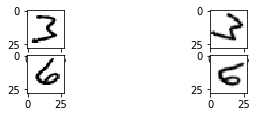

In [8]:
for i in range(2):
    plt.subplot(5,2,i*2+1)
    idx=random.randrange(0,x_train.shape[0])
    plt.imshow(x_train[idx], cmap="gray_r")
    #plt.show()
    imgr=rotate(x_train[idx],30)
    plt.subplot(5,2,i*2+2)
    plt.imshow(imgr,cmap="gray_r")
plt.show()

In [25]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_dx,tr_dy,tr_pairs, tr_y = create_pairs_intra(x_train, digit_indices,10)

digit_indices = [np.where(y_test  == i)[0] for i in range(num_classes)]
te_dx,tr_dy,te_pairs, te_y = create_pairs_intra(x_test, digit_indices,10)

print("tr_pairs=",tr_pairs.shape,"tr_y=",tr_y.shape,tr_y.dtype)
print("te_pairs=",te_pairs.shape,"te_y=",te_y.shape,te_y.dtype)

tr_pairs= (3700, 2, 28, 28, 1) tr_y= (3700, 2) float32
te_pairs= (3700, 2, 28, 28, 1) te_y= (3700, 2) float32


In [40]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


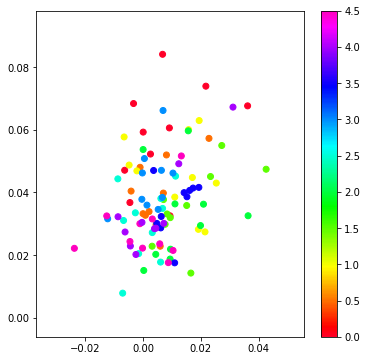

In [41]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=tr_dy,cmap=plt.get_cmap("gist_rainbow"))
plt.colorbar()
plt.show()

In [42]:
# train
epochs = 10
batch_size=1000
rms = RMSprop()
model.compile(loss=contrastive_loss_intra_easy, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))


Train on 3700 samples, validate on 3700 samples
Epoch 1/10
3700/3700 [==============================] - 2s 425us/sample - loss: 0.7674 - accuracy: 0.5029 - val_loss: 0.1744 - val_accuracy: 0.5270
Epoch 2/10
3700/3700 [==============================] - 1s 194us/sample - loss: 0.1842 - accuracy: 0.5346 - val_loss: 0.1440 - val_accuracy: 0.5392
Epoch 3/10
3700/3700 [==============================] - 1s 193us/sample - loss: 0.0837 - accuracy: 0.5210 - val_loss: 0.1333 - val_accuracy: 0.5334
Epoch 4/10
3700/3700 [==============================] - 1s 197us/sample - loss: 0.0542 - accuracy: 0.5315 - val_loss: 0.1040 - val_accuracy: 0.5422
Epoch 5/10
3700/3700 [==============================] - 1s 205us/sample - loss: 0.0350 - accuracy: 0.5269 - val_loss: 0.0995 - val_accuracy: 0.5400
Epoch 6/10
3700/3700 [==============================] - 1s 199us/sample - loss: 0.0528 - accuracy: 0.5262 - val_loss: 0.0873 - val_accuracy: 0.5436
Epoch 7/10
3700/3700 [==============================] - 1s 204us

In [43]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 51.08%
* Accuracy on test set: 51.15%


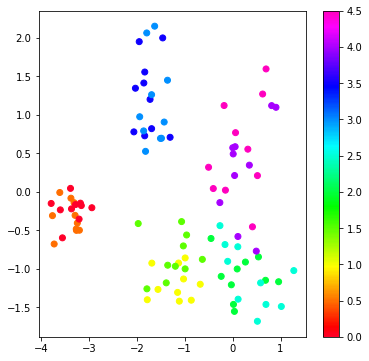

In [44]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=tr_dy,cmap=plt.get_cmap("gist_rainbow"))
plt.colorbar()
plt.show()

In [15]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_dx,tr_dy,tr_pairs, tr_y = create_pairs_intra(x_train, digit_indices,100,[4,9])
print("tr_pairs=",tr_pairs.shape,"tr_y=",tr_y.shape,tr_y.dtype)

tr_pairs= (30700, 2, 28, 28, 1) tr_y= (30700, 2) float32


In [16]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


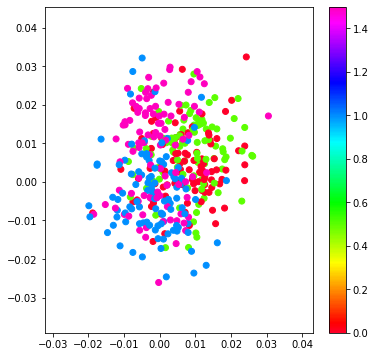

In [17]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=tr_dy,cmap=plt.get_cmap("gist_rainbow"))
plt.colorbar()
plt.show()

In [23]:
# train
epochs = 100
batch_size=1000
rms = RMSprop()
model.compile(loss=contrastive_loss_intra_easy, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))


Train on 30700 samples, validate on 3700 samples
Epoch 1/100
30700/30700 [==============================] - 6s 195us/sample - loss: 0.0196 - accuracy: 0.3995 - val_loss: 0.3732 - val_accuracy: 0.5151
Epoch 2/100
30700/30700 [==============================] - 4s 146us/sample - loss: 0.0020 - accuracy: 0.4097 - val_loss: 0.4017 - val_accuracy: 0.4982
Epoch 3/100
30700/30700 [==============================] - 5s 147us/sample - loss: 0.0021 - accuracy: 0.4386 - val_loss: 0.3532 - val_accuracy: 0.5195
Epoch 4/100
30700/30700 [==============================] - 5s 147us/sample - loss: 0.0063 - accuracy: 0.4623 - val_loss: 0.3275 - val_accuracy: 0.5167
Epoch 5/100
30700/30700 [==============================] - 5s 148us/sample - loss: 1.4490e-04 - accuracy: 0.4700 - val_loss: 0.2784 - val_accuracy: 0.5316
Epoch 6/100
30700/30700 [==============================] - 5s 148us/sample - loss: 0.0013 - accuracy: 0.4755 - val_loss: 0.3595 - val_accuracy: 0.5435
Epoch 7/100
30700/30700 [================

30700/30700 [==============================] - 5s 147us/sample - loss: 0.0000e+00 - accuracy: 0.5017 - val_loss: 0.2812 - val_accuracy: 0.5324
Epoch 54/100
30700/30700 [==============================] - 5s 147us/sample - loss: 0.0000e+00 - accuracy: 0.4988 - val_loss: 0.2812 - val_accuracy: 0.5324
Epoch 55/100
30700/30700 [==============================] - 5s 147us/sample - loss: 0.0000e+00 - accuracy: 0.4994 - val_loss: 0.2812 - val_accuracy: 0.5324
Epoch 56/100
30700/30700 [==============================] - 5s 147us/sample - loss: 0.0000e+00 - accuracy: 0.4945 - val_loss: 0.2812 - val_accuracy: 0.5324
Epoch 57/100
30700/30700 [==============================] - 5s 147us/sample - loss: 0.0000e+00 - accuracy: 0.4933 - val_loss: 0.2812 - val_accuracy: 0.5324
Epoch 58/100
30700/30700 [==============================] - 5s 147us/sample - loss: 0.0000e+00 - accuracy: 0.4990 - val_loss: 0.2812 - val_accuracy: 0.5324
Epoch 59/100
30700/30700 [==============================] - 5s 147us/sample -

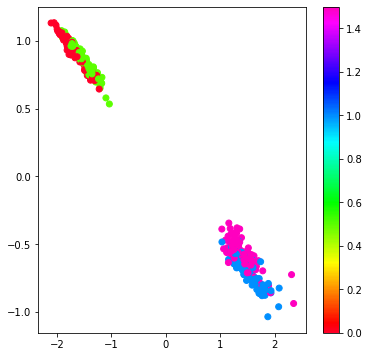

In [24]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=tr_dy,cmap=plt.get_cmap("gist_rainbow"))
plt.colorbar()
plt.show()